In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [ ]:
#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91195003)

#for an easy reset backend session state
tf.keras.backend.clear_session()

In [ ]:
#load dataset
def load_dataset(path):
  return pd.read_csv(path)

In [ ]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0,int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)* (100-perc)/100+1),len(training))
  return train_idx, val_idx


In [ ]:
#preparing the data for the LSTM
def prepare_data(df):
        #retirar a ultima row porque tem valores errados 
        df_raw = df.drop([60])
        #Get pair to evaluate for time series
        #We are going to predict the opening value for each day
        df_raw["data"] = pd.to_datetime(df_raw["data"])
        df_raw = df_raw.sort_values("data")
        df_raw = df_raw.set_index("data")
        df_raw = df_raw.reindex(columns=['obitos', 'confirmados_arsnorte', 'confirmados_arscentro', 'confirmados_arslvt',
                                        'confirmados_arsalentejo', 'confirmados_arsalgarve',
                                        'confirmados_acores', 'confirmados_madeira', 'confirmados_novos',
                                        'recuperados', 'internados', 'internados_uci', 'vigilancia',
                                        'confirmados_0_9_f', 'confirmados_0_9_m', 'confirmados_10_19_f',
                                        'confirmados_10_19_m', 'confirmados_20_29_f', 'confirmados_20_29_m',
                                        'confirmados_30_39_f', 'confirmados_30_39_m', 'confirmados_40_49_f',
                                        'confirmados_40_49_m', 'confirmados_50_59_f', 'confirmados_50_59_m',
                                        'confirmados_60_69_f', 'confirmados_60_69_m', 'confirmados_70_79_f',
                                        'confirmados_70_79_m', 'confirmados_80_plus_f', 'confirmados_80_plus_m',
                                        'confirmados_f', 'confirmados_m', 'obitos_arsnorte', 'obitos_arscentro',
                                        'obitos_arslvt', 'obitos_arsalentejo', 'obitos_arsalgarve',
                                        'obitos_acores', 'obitos_madeira', 'obitos_0_9_f', 'obitos_0_9_m',
                                        'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
                                        'obitos_30_39_f', 'obitos_30_39_m', 'obitos_40_49_f', 'obitos_40_49_m',
                                        'obitos_50_59_f', 'obitos_50_59_m', 'obitos_60_69_f', 'obitos_60_69_m',
                                        'obitos_70_79_f', 'obitos_70_79_m', 'obitos_80_plus_f',
                                        'obitos_80_plus_m', 'obitos_f', 'obitos_m', 'ativos',
                                        'internados_enfermaria', 'Rt_número_de_reprodução', 'Max_Temp',
                                        'Min_Temp', 'Temperature', 'Precipitation', 'Wind_Speed',
                                        'Wind_Direction', 'Visibility', 'Cloud_Cover', 'Relative_Humidity',
                                        'Rain', 'Clear', 'Partially_cloudy', 'flights', 'commercial_flights'])
        # drop de features com correlação alta a outras
        df_raw = df_raw.drop(columns=['Rain','Max_Temp','Min_Temp','internados_enfermaria','confirmados_0_9_m','confirmados_10_19_f', 
                                'confirmados_10_19_m', 'confirmados_20_29_f', 'confirmados_20_29_m', 'confirmados_30_39_f', 
                                'confirmados_30_39_m','confirmados_40_49_f', 'confirmados_40_49_m', 'confirmados_50_59_f', 
                                'confirmados_50_59_m', 'confirmados_60_69_f', 'confirmados_60_69_m', 'confirmados_70_79_f', 
                                'confirmados_70_79_m', 'confirmados_80_plus_f', 'obitos_30_39_f', 'obitos_30_39_m', 'obitos_40_49_f', 
                                'obitos_40_49_m', 'obitos_50_59_f', 'obitos_50_59_m', 'obitos_60_69_f', 'obitos_60_69_m', 'obitos_70_79_f', 
                                'obitos_70_79_m', 'obitos_80_plus_f','obitos_80_plus_m','confirmados_m', 'confirmados_f',
                                'confirmados_arscentro', 'confirmados_arslvt', 'confirmados_arsalentejo', 'confirmados_arsalgarve',
                                'obitos_arsalgarve','obitos_arsalentejo','obitos_arslvt', 'obitos_f', 'obitos_m'])
        # fazer drop das colunas descartadas pelo feature selection
        df_raw = df_raw.drop(columns=['obitos_arscentro', 'obitos_madeira', 'obitos_0_9_f', 'obitos_0_9_m', 'obitos_10_19_f',
                    'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m', 'ativos', 'Rt_número_de_reprodução', 'Temperature', 'Cloud_Cover',
                    'Clear', 'Partially_cloudy', 'commercial_flights'])
        # df_raw = df_raw.drop(columns=[ 'obitos_0_9_f', 'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
        #                               'ativos', 'Partially_cloudy', 'commercial_flights'])
        return df_raw


In [ ]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    colunas = [x for x in df.columns if x != 'obitos']
    print(colunas)
    for col in colunas:
      df[[col]] = scaler.fit_transform(df[[col]])
    df[['obitos']] = scaler.fit_transform(df[['obitos']])
    
    return scaler

In [ ]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()


In [ ]:
#Plot time series data
def plot_confirmed_cases(data):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)), data)
        plt.title('Dataset Features')
        plt.ylabel('Valores')
        plt.xlabel('Semanas')
        plt.show()

In [ ]:
#Preparing the dataset for the CNN
def to_supervised(df, timesteps):
  data = df.values
  X,y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of the timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index,:])
      y.append(data[input_index:label_index,0])
        #using np.flot32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [ ]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [ ]:
def build_model(timesteps, features, filters= 16, kernel_size=5, pool_size =2 ):
  #using the functional API
  inputs = tf.keras.layers.Input(shape=(timesteps, features))
  #microarchitecture
  x = tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation='relu', data_format = 'channels_last')(inputs)
  x = tf.keras.layers.AveragePooling1D(pool_size = pool_size, data_format = 'channels_first')(x)
  #last layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(filters)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  #the model
  cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')
  tf.keras.utils.plot_model(cnnModel,'cnnmodel.png', show_shapes=True)
  return cnnModel

In [ ]:
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss=rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae',rmse])
  #fit
  hist_list = list()
  loss_list = list()
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,shuffle=False)
    metrics = model.evaluate(X_test, y_test)

    plot_learning_curves(history, epochs)
    hist_list.append(history)

  return model, hist_list

In [ ]:
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = df[-timesteps:].values #getting the last sequence of known value
  inp = input_seq
  forecasts = list()
  print(inp)
  #multistep tells us how many iterations we want to perform
  #i. e. how many days we want to predict
  for step in range(1, multisteps+1):
    #implement
    inp = inp.reshape(1, timesteps, n_variate)
    pred = model.predict(inp)
    yhat_inversed = scaler.inverse_transform(pred)
    forecasts.append(yhat_inversed)
    #prepare new input to forecast the next day
    # inp = np.append(inp[0], pred)        
    # inp = inp[-timesteps:]
    # list_pred = [pred[0][i] for i in range(len(pred[0]))]
    # print('list_yhat:')
    # print(list_pred)
    # inp= np.append(inp[0],[list_pred],axis=0) #adiciona previsão recente ao input
    # inp = inp[-timesteps:]#vai ao input buscar os ultimos timesteps registados
    # print(step)
    print(step)
            
  return forecasts

In [ ]:
def plot_forecast(data, forecasts):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)),data["obitos"], color='green', label='Confirmed')
        
        fi=[]
        for f in forecasts:
          fi.append(f[0][0])
          print('Previsão:' + str(f))
        print(fi)
        
        plt.plot(range(len(data)-1,len(data)+len(fi)-1), fi, color='red', label='Forecasts')
    
        plt.title('Predicted Pice of the S&P500')
        plt.ylabel('Price')
        plt.xlabel('Days')
        plt.legend()
        plt.show()

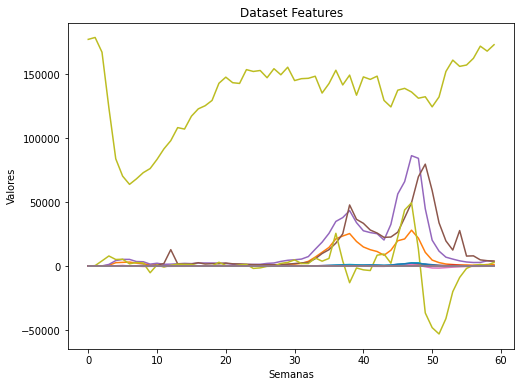

['confirmados_arsnorte', 'confirmados_acores', 'confirmados_madeira', 'confirmados_novos', 'recuperados', 'internados', 'internados_uci', 'vigilancia', 'confirmados_0_9_f', 'confirmados_80_plus_m', 'obitos_arsnorte', 'obitos_acores', 'Precipitation', 'Wind_Speed', 'Wind_Direction', 'Visibility', 'Relative_Humidity', 'flights']
Epoch 1/10
3/3 [==============================] - 1s 149ms/step - loss: 0.3873 - mae: 0.3725 - rmse: 0.3738 - val_loss: 0.1836 - val_mae: 0.1836 - val_rmse: 0.1836
Epoch 2/10
3/3 [==============================] - 0s 34ms/step - loss: 0.1682 - mae: 0.1449 - rmse: 0.1715 - val_loss: 0.4628 - val_mae: 0.4628 - val_rmse: 0.4628
Epoch 3/10
3/3 [==============================] - 0s 36ms/step - loss: 0.1966 - mae: 0.1791 - rmse: 0.1993 - val_loss: 0.3986 - val_mae: 0.3986 - val_rmse: 0.3986
Epoch 4/10
3/3 [==============================] - 0s 43ms/step - loss: 0.1516 - mae: 0.1296 - rmse: 0.1497 - val_loss: 0.2136 - val_mae: 0.2136 - val_rmse: 0.2136
Epoch 5/10
3/3 [==

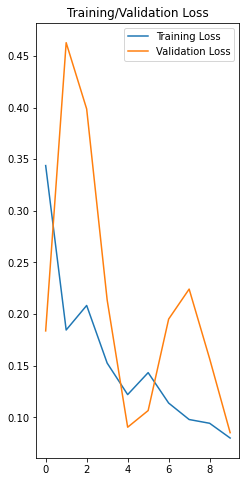

Epoch 1/10
5/5 [==============================] - 0s 35ms/step - loss: 0.1009 - mae: 0.0871 - rmse: 0.1009 - val_loss: 0.1106 - val_mae: 0.1063 - val_rmse: 0.1106
Epoch 2/10
5/5 [==============================] - 0s 19ms/step - loss: 0.0758 - mae: 0.0630 - rmse: 0.0758 - val_loss: 0.0598 - val_mae: 0.0524 - val_rmse: 0.0598
Epoch 3/10
5/5 [==============================] - 0s 19ms/step - loss: 0.0729 - mae: 0.0625 - rmse: 0.0729 - val_loss: 0.0857 - val_mae: 0.0820 - val_rmse: 0.0857
Epoch 4/10
5/5 [==============================] - 0s 18ms/step - loss: 0.0534 - mae: 0.0478 - rmse: 0.0534 - val_loss: 0.0592 - val_mae: 0.0551 - val_rmse: 0.0592
Epoch 5/10
5/5 [==============================] - 0s 21ms/step - loss: 0.0531 - mae: 0.0457 - rmse: 0.0531 - val_loss: 0.0693 - val_mae: 0.0672 - val_rmse: 0.0693
Epoch 6/10
5/5 [==============================] - 0s 21ms/step - loss: 0.0487 - mae: 0.0457 - rmse: 0.0487 - val_loss: 0.0426 - val_mae: 0.0412 - val_rmse: 0.0426
Epoch 7/10
5/5 [======

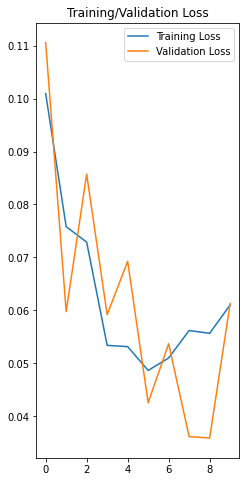

Epoch 1/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0848 - mae: 0.0682 - rmse: 0.0819 - val_loss: 0.1703 - val_mae: 0.1136 - val_rmse: 0.1703
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0631 - mae: 0.0507 - rmse: 0.0576 - val_loss: 0.1594 - val_mae: 0.1049 - val_rmse: 0.1594
Epoch 3/10
8/8 [==============================] - 0s 14ms/step - loss: 0.1025 - mae: 0.0879 - rmse: 0.1032 - val_loss: 0.1491 - val_mae: 0.1305 - val_rmse: 0.1491
Epoch 4/10
8/8 [==============================] - 0s 14ms/step - loss: 0.0871 - mae: 0.0766 - rmse: 0.0827 - val_loss: 0.1535 - val_mae: 0.1005 - val_rmse: 0.1535
Epoch 5/10
8/8 [==============================] - 0s 16ms/step - loss: 0.1452 - mae: 0.1378 - rmse: 0.1307 - val_loss: 0.1516 - val_mae: 0.1049 - val_rmse: 0.1516
Epoch 6/10
8/8 [==============================] - 0s 14ms/step - loss: 0.0914 - mae: 0.0780 - rmse: 0.0867 - val_loss: 0.1467 - val_mae: 0.1042 - val_rmse: 0.1467
Epoch 7/10
8/8 [======

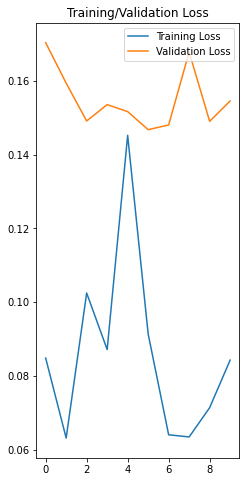

[[-9.16542474e-01 -9.30196190e-01 -6.92929293e-01 -4.98985801e-01
  -9.24226464e-01 -8.01843145e-01 -5.11322133e-02 -4.05594406e-01
  -9.75181628e-06 -9.50801342e-01 -9.16398714e-01 -9.62264151e-01
  -1.00000000e+00 -1.00000000e+00  9.14798206e-01 -9.20685803e-01
   3.22957198e-01 -1.00000000e+00  6.24923499e-01]
 [-9.31445604e-01 -9.47469434e-01 -6.72727273e-01 -5.98377282e-01
  -9.33394298e-01 -7.97580089e-01  6.57414171e-03 -9.79020979e-02
   4.57262665e-02 -9.64219158e-01 -9.05144695e-01 -9.48113208e-01
  -6.00000000e-01 -1.00000000e+00 -2.30941704e-01  1.02360484e-02
   3.15175097e-01 -3.73719162e-01  7.16000179e-01]
 [-9.58271237e-01 -9.37304521e-01 -7.93939394e-01 -7.48478702e-01
  -9.32213592e-01 -8.76346311e-01  1.82615047e-02 -7.69230769e-02
   6.01979619e-02 -8.89675736e-01 -9.22829582e-01 -9.66981132e-01
  -1.00000000e+00 -9.26534741e-01  4.93273543e-02 -1.84054592e-01
   1.67315175e-01  1.12172842e-01  8.81624448e-01]
 [-9.63238947e-01 -9.07094114e-01  6.66666667e-02 -6.73

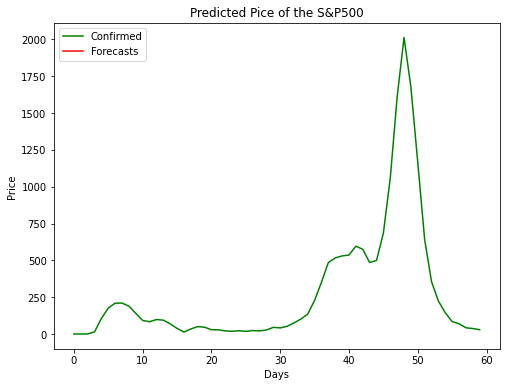

[array([[45.751457]], dtype=float32)]


In [ ]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

n_variate = 4 #1, 2, 3  # number of features used by the model (using conf. cases to predict conf. cases) 

#the dataframes

df_raw = load_dataset('covid_portugal.csv')
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)
plot_confirmed_cases(df_data) #the plot you saw previously
scaler = data_normalization(df) #scaling data to [-1,1]


##Optimization

tunning_dict = {
                  1: {'timesteps' : 5, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 }#,
                  #2: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                  #3: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                  #
                  #4: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                  #5: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                  #6: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                  #
                  #7: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                  #8: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                  #9: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

  }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
   # print(record[r])
   # fitting the model
   timesteps = tunning_dict[t]['timesteps']
   epochs = tunning_dict[t]['epochs']
   batch_size = tunning_dict[t]['batch_size']
   multisteps = tunning_dict[t]['multisteps']
   cv_splits = tunning_dict[t]['cv_splits']
   # print(timesteps,epochs,batch_size,cv_splits)

   X, y = to_supervised(df, timesteps)

   model = build_model(timesteps, n_variate)
   model, history = compile_and_fit(model, epochs, batch_size)
   # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
   forecasts = forecast(model, df, timesteps, multisteps, scaler)
   plot_forecast(df_data, forecasts)
   print(forecasts)

   prev = []

   record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
      # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
      # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
      # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
      # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
      loss.append(sum(h.history['loss']) / len(h.history['loss']))
      mae.append(sum(h.history['mae']) / len(h.history['mae']))
      rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
      val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
      val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
      val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
      id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




In [ ]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.10086262313028177, 0.0875071513156096, 0.09776540212333203, 0.1426882608483235, 0.12633008857568107, 0.1426882608483235] 



,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.100863,0.087507,0.097765,0.142688,0.12633,0.142688


In [ ]:
#Results metrics to a file
final_df.to_csv(r"resultados_cnn_covid.csv",index=True)